In [4]:
from utilities import *
fig_path = '/Users/ling/MyDocuments/Thesis/PHAS0077/ucl-latex-thesis-templates/assets/'

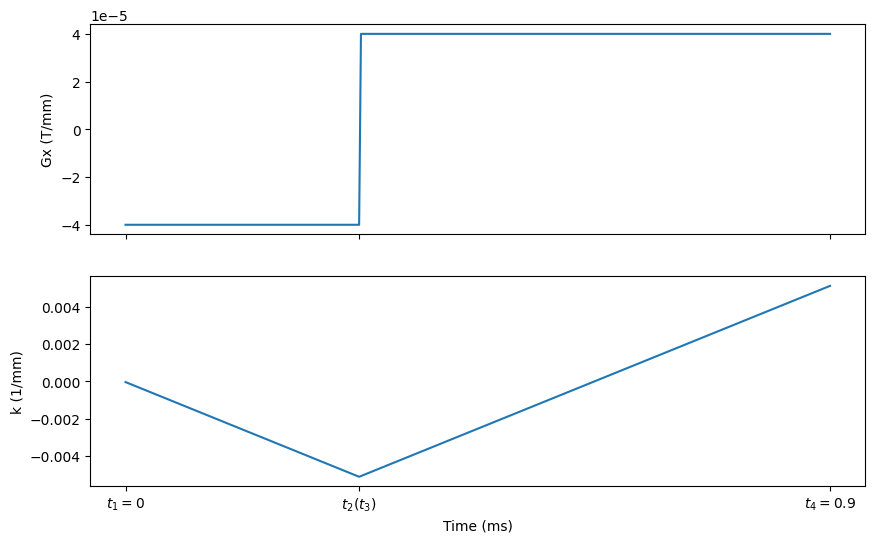

In [5]:
# Environment Setup

# x space (spatial space)
FOV_x = 256 # field of view in x space
N = 256 # sampling points in x space (and k space, time space during ADC)
delta_x = FOV_x / N # sampling interval in x space
x_axis = np.linspace(-FOV_x / 2, FOV_x / 2 - delta_x, N) # symmetric x space

# k space (frequency space)
delta_k = 1 / FOV_x # sampling interval in k space
FOV_k = delta_k * N # field of view in k space
k_axis = np.linspace(-FOV_k / 2, FOV_k / 2 - delta_k, N) # symmetric k space

# gradient
Gx = 4e-5 # gradient (T/mm). Note: constant gradient. if gradient is not constant, delta_t will change based on Gx and delta_k?
gamma = 2.68e5 # rad/ms/T
gamma_bar = 0.5 * gamma/np.pi # ms^-1T^-1

# t space (time space)
gamma_bar_Gx = gamma_bar * Gx
delta_t = delta_k / gamma_bar_Gx # sampling interval in t space (ms)
Ts = FOV_k / gamma_bar_Gx # ADC(rephasing) time (ms)
t_max = 1.5 * Ts - delta_t # maximum time (ms) (rephasing process is 2 times longer than dephasing process)
t_axis = np.linspace(0, t_max, int(N * 1.5))

# Environment Display
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 6))

G_values = np.concatenate((np.ones(int(N / 2)) * -Gx, np.ones(N) * Gx))
ax1.plot(t_axis, G_values)
ax1.set_ylabel('Gx (T/mm)')

k_traj = np.cumsum(G_values)
ax2.plot(t_axis, k_traj)
ax2.set_ylabel('k (1/mm)')
ax2.set_xlabel('Time (ms)')

ax2.set_xticks([0,t_axis[int(N / 2) - 1],t_axis[int(N * 1.5) - 1]])
ax2.set_xticklabels(['$t_1=0$', r'$t_2 (t_3)$', r'$t_4=$' + str(round(t_axis[int(N * 1.5) - 1], 1))])
fig.savefig(fig_path + 'G_K_traj.png', dpi=300, bbox_inches='tight')

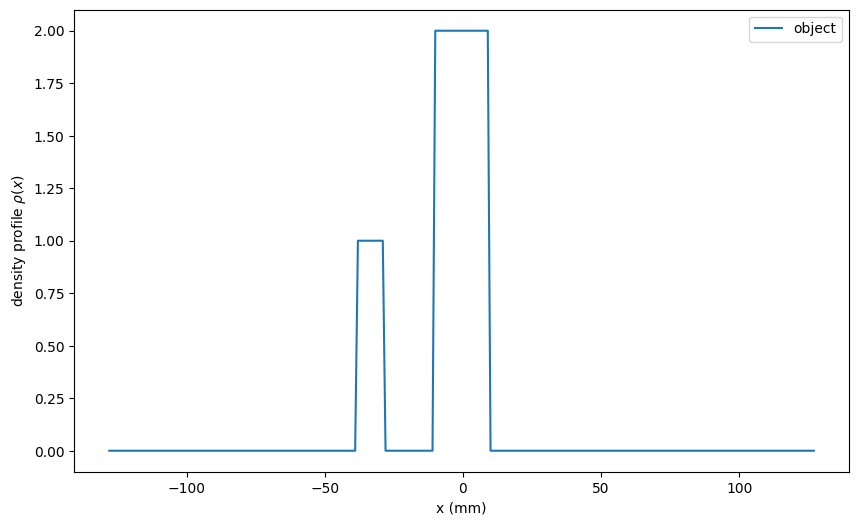

In [7]:
# create object
density = np.zeros(len(x_axis))
density[100-10: 100] = 1
density[128 - 10:128 + 10] = 2

plt.figure(figsize=(10, 6))
plt.plot(x_axis, density, '-', label='object')
plt.legend()
plt.xlabel('x (mm)')
plt.ylabel(r'density profile $\rho(x)$')
# plt.grid()
plt.savefig(fig_path + 'density_profile.png', dpi=300)

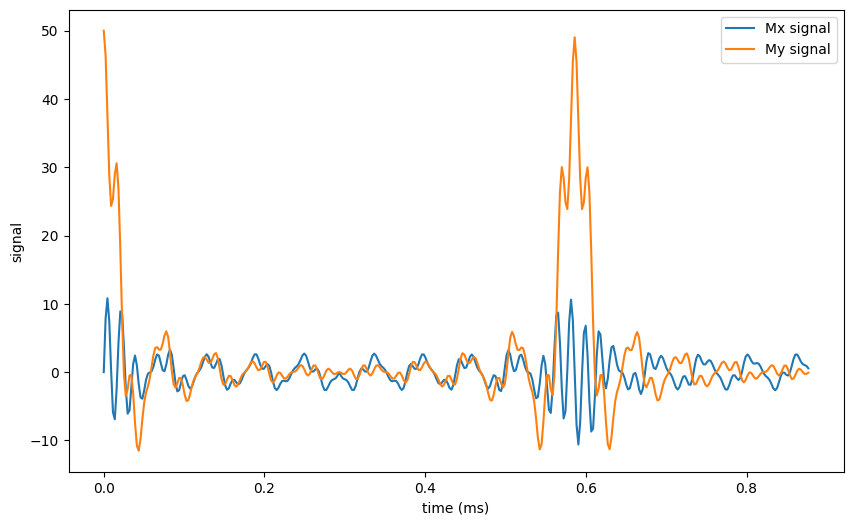

In [8]:
# create spins after the rf pulse (lying on the y-axis)
# assume the spins are lying on each sampling point over y-axis
m0 = 1.0
w_0 = 0
vec_spins = np.zeros((3, N))
vec_spins[1, :] = 1

# define larmor frequency w_G of spins during relaxation
# shape = (number of time steps, number of sampling points)
w_G = np.outer(G_values, x_axis) * gamma + w_0

res = multiple_Relaxation(vec_spins, m0=m0, w=0, w0=w_G, t1=1e10, t2=3e1, t_axis=t_axis, steps=int(N*1.5), axis='z')

store = []
for i in range(2):
    tmp = res[i,:,:].squeeze() # shape: (number of steps, number of sampling points)
    
    store.append(tmp @ density) # multiply by true density

Mx_1, My_1 = store[0][:int(N/2)], store[1][:int(N/2)]
Mx_2, My_2 = store[0][int(N/2):], store[1][int(N/2):]

# plot the full signal
signal_Mx = np.concatenate((Mx_1, Mx_2), axis=0)
signal_My = np.concatenate((My_1, My_2), axis=0)
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(t_axis, signal_Mx, label='Mx signal')
plt.plot(t_axis, signal_My, label='My signal')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('signal')

# print(Mx_2[:10])
# print(My_2[:10])
fig.savefig(fig_path + 'signal.png', dpi=300, bbox_inches='tight')

1.4142135623730951


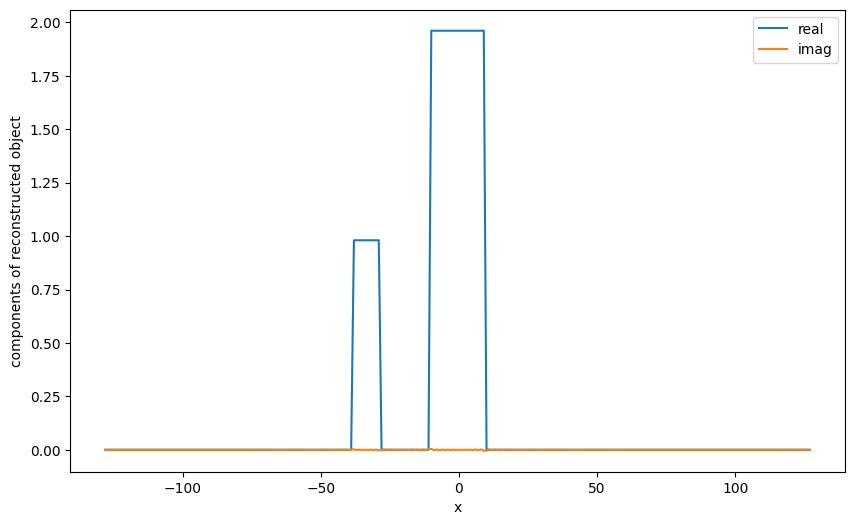

In [9]:
# ifft of the signal when the ADC on
adc_signal = Mx_2 * (-1j) + 1 * My_2

re_density = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(adc_signal)))
plt.figure(figsize=(10, 6))
plt.plot(x_axis, np.real(re_density), label='real')
plt.plot(x_axis, np.imag(re_density), label='imag')
plt.legend()
plt.xlabel('x')
plt.ylabel('components of reconstructed object')
plt.savefig(fig_path + 'reconstructed_object.png', dpi=300)
print(np.abs(1+1j))

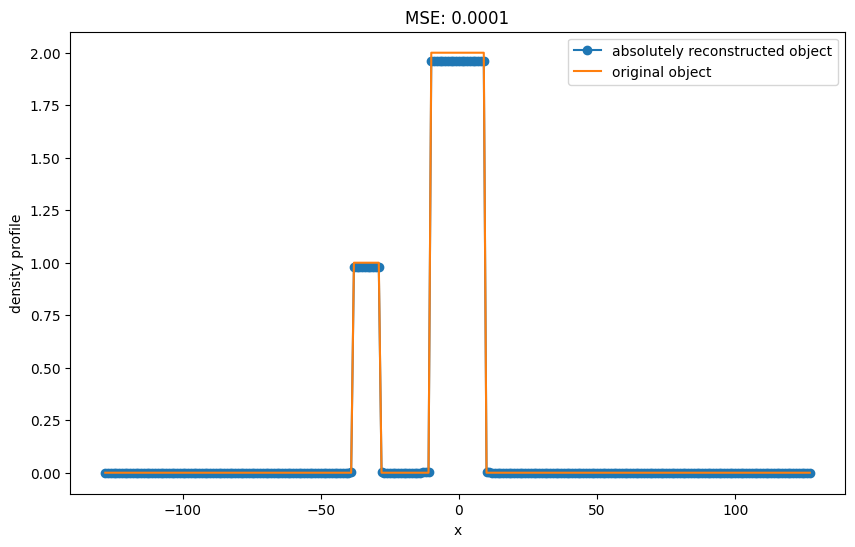

In [13]:
# plot the absolutely reconstructed density
plt.figure(figsize=(10, 6))
plt.plot(x_axis, np.abs(re_density),'-o', label='absolutely reconstructed object')
plt.plot(x_axis, density, label='original object')
plt.legend()
plt.xlabel('x')
plt.ylabel('density profile')

# calculate the error
mse = (np.square(np.abs(re_density) - density)).mean()
plt.title('MSE: {:.4f}'.format(mse))
plt.savefig(fig_path + 'final_recon.png', dpi=300, bbox_inches='tight')
